In [15]:
from agent import Agent
from agent_distribution import AgentDistribution
from utils import fixed_point_interpolation_true_distribution, compute_score_bounds
import matplotlib.pyplot as plt
import numpy as np
from gradient_expected import expected_gradient_loss_s
from scipy.stats import bernoulli, norm
import tqdm
import numpy as np

In [35]:
def empirical_gradient_pi_s(agent_dist, beta, s, sigma, q, perturbation_size=0.05):
    """Method that returns the empirical gradient of pi wrt to s incurred given an agent distribution and model and threshold.
    Assumes that there is an model true_beta when applied to the agents' hidden eta features
    optimally selects the top agents.

    Keyword args:
    agent_dist -- AgentDistribution
    beta -- model parameters (N, 1) array
    s -- threshold (float)
    sigma -- standard deviation of noise distribution (float)
    q -- quantile

    Returns:
    gamma_loss_s -- empirical gradient dL/ds
    """
        
    perturbations = (2 * bernoulli.rvs(p=0.5, size=agent_dist.n).reshape(agent_dist.n, 1) -1 ) * perturbation_size
    scores = []
    
    bounds = compute_score_bounds(beta)
    interpolators = []
    
    for agent in agent_dist.agents:
        interpolators.append(agent.br_score_function_s(beta, sigma))
    
    for i in range(agent_dist.n):
        s_perturbed = np.clip(s + perturbations[i], a_min=bounds[0], a_max=bounds[1])
        agent_type = agent_dist.n_agent_types[i]
        br_score = interpolators[agent_type](s_perturbed)
        scores.append(br_score.item())
        
    scores = np.array(scores).reshape(agent_dist.n, 1)
    noise = norm.rvs(loc=0., scale=sigma, size=agent_dist.n).reshape(agent_dist.n, 1)
    noisy_scores = np.clip(scores + noise, a_min=bounds[0], a_max=bounds[1])
    
    perturbed_noisy_scores =  noisy_scores - perturbations
    
    non_treatments = perturbed_noisy_scores <= np.quantile(perturbed_noisy_scores, q)
    
    Q = np.matmul(perturbations.T, perturbations)
    gamma_pi_s = np.linalg.solve(Q, np.matmul(perturbations.T, non_treatments))
    return gamma_pi_s.item()

In [36]:
def expected_gradient_pi_s(agent_dist, theta, sigma, f):
    """Method computes partial pi/partial s.

    Keyword args:
    agent_dist -- AgentDistribution
    beta -- model parameters
    sigma -- standard deviation of noise distribution
    f -- function that maps arctan(beta[1]/beta[0]) -> s_beta (fixed point)


    Returns:
    d_pi_d_s -- expected gradient wrt to s of policy loss 

    """
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)

    beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
    bounds = compute_score_bounds(beta)
    s = np.clip(f(theta), a_min=bounds[0], a_max = bounds[1])
    
    br_dist, grad_s_dist  = agent_dist.br_gradient_s_distribution(beta, s, sigma)
    
    z = s - np.array([np.matmul(beta.T, x) for x in  br_dist]).reshape(len(br_dist), 1)
    
    prob = norm.pdf(z, loc=0., scale=sigma)
    vec = np.array([1 - np.matmul(beta.T, grad_s_dist[i]).item() for i in range(len(br_dist))]).reshape(agent_dist.n_types, 1)
    res = prob * vec * agent_dist.prop.reshape(agent_dist.n_types, 1)

    d_l_d_s = np.sum(res)
    return d_l_d_s.item()

In [37]:
agent_dist = AgentDistribution(n=10000, n_types=10)
sigma = 0.35
q = 0.7

In [38]:
f = fixed_point_interpolation_true_distribution(agent_dist, 0.35, 0.7, plot=False, savefig=None)

Computing fixed points...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


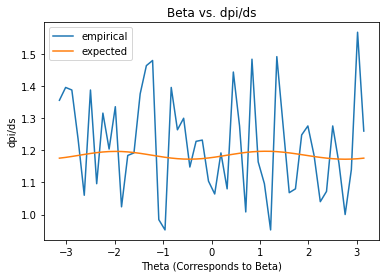

In [39]:
def plot_grad_pi_s(agent_dist, sigma, q, f, true_beta=None, savefig=None):
    emp_grad_s = []
    grad_s = []
    thetas = np.linspace(-np.pi, np.pi, 50)
    sigma = 0.35
    q = 0.7
    for theta in thetas:
        s_beta = f(theta)
        beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
        emp_grad = empirical_gradient_pi_s(agent_dist, beta, s_beta, sigma, q)
        grad = expected_gradient_pi_s(agent_dist, theta, sigma, f)
        emp_grad_s.append(emp_grad)
        grad_s.append(grad)
    plt.plot(thetas, emp_grad_s, label="empirical")
    plt.plot(thetas, grad_s, label="expected")
    plt.legend()
    plt.xlabel("Theta (Corresponds to Beta)")
    plt.ylabel("dpi/ds")
    plt.title("Beta vs. dpi/ds")
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    plt.close()
    
plot_grad_pi_s(agent_dist, sigma, q, f, savefig="figs/dpi_ds.pdf")